# SVM and Logistic Regression Modeling

# World Development Indicators (WDI) Data Set


## Logistic Regression Model

Please carefully describe every assumption and every step in your report.  
  
  [50 points] Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use
80/20 training/testing split for your data). Adjust parameters of the models to make them more
accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel
only is fine to use.  


## Support Vector Machine Model  
  
  Please carefully describe every assumption and every step in your report.  
    
    
[50 points] Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.

Below we will go through the creation of three different Support Vector Machines, or SVMs, and examine visual representations of their predictions.  These SVMs will be relatively simple, and only predict based on a given combination of two predictive variables.  This is done so that we can more clearly represent the visualization in a plot.  After these representations we will have another section where we will build and run a more complex SVM which includes more predictive variables and will result in a much higher accuracy.

### Please note that the following code found in this section is based upon concepts and examples found in Chapter 3 of "Machine Learning in Python" by Sebastian Raschka

In [1]:
# This code imports the packages we will be using, and sets parameters for the matplotlib.pylab package.

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%matplotlib inline

import graphlab as gl
import graphlab
# keep data visualizations within notebook
graphlab.canvas.set_target('ipynb')

In [2]:
df_income = None
df_final_income = None
sf_final_2014 = None
df_indicators = None
df_flt = None
df_s = None
df_all = None
df_all_2014 = None

In [3]:
# Path to where all of the data set files resides 
path = 'data'

In [4]:
filename = path + '\Indicators.csv'
df_indicators = pd.read_csv(filename) # read in the csv file
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656458 entries, 0 to 5656457
Data columns (total 6 columns):
CountryName      object
CountryCode      object
IndicatorName    object
IndicatorCode    object
Year             int64
Value            float64
dtypes: float64(1), int64(1), object(4)
memory usage: 258.9+ MB


In [5]:
df_indicators.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


In [6]:
# This code merges the data into a more easily manipulated pivot table format.
df_flt = df_indicators[df_indicators.IndicatorCode.isin(['SL.TLF.CACT.MA.ZS','NY.GDP.MKTP.CD','NY.GDP.PCAP.CD','SP.ADO.TFRT'
                                                 ,'SG.GEN.PARL.ZS'])]
df_s = df_flt[['Year','CountryCode','IndicatorCode','Value']]
df_s =df_s.pivot_table(index=['CountryCode','Year'], columns=['IndicatorCode'], values=['Value'])
df_all = df_s['Value']
df_all.reset_index(inplace=True)
df_all.columns.name=None

In [7]:
# For the purposes of these SVMs we will only be interested in values for these countries from the year 2014.
df_all_2014 = df_all[df_all['Year']==2014] 

In [8]:
# This code Imputes missing values in the data based upon a spline method.
df_all_2014 =df_all_2014.reindex(index=df_all_2014.index[::-1])
df_all_2014.interpolate(method='barycentric',order=1, limit_direction='both', inplace=True)
df_all_2014 =df_all_2014.reindex(index=df_all_2014.index[::-1])
df_all_2014.interpolate(method='spline',order=1, limit_direction='both', inplace=True)
df_all_2014

C:\Users\Ben\Anaconda6\envs\gl-env\lib\site-packages\scipy\interpolate\fitpack2.py:222: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


,CountryCode,Year,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,SG.GEN.PARL.ZS,SL.TLF.CACT.MA.ZS,SP.ADO.TFRT
54,ABW,2014,NaN,NaN,NaN,NaN,23.122000
99,ADO,2014,NaN,NaN,50.000000,NaN,47.228253
155,AFG,2014,2.003822e+10,633.569247,27.700000,79.300003,76.733600
211,AGO,2014,1.662486e+10,2598.890818,36.800000,76.800003,166.602800
267,ALB,2014,1.321151e+10,4564.390339,20.000000,65.599998,21.489600
323,ARB,2014,2.845788e+12,7386.428444,17.793970,75.572081,48.228153
379,ARE,2014,3.994513e+11,43962.713693,17.500000,92.900002,29.253800
435,ARG,2014,5.376600e+11,12509.531118,36.600000,75.099998,63.851200
491,ARM,2014,1.164444e+10,3873.533566,10.700000,73.099998,23.508400
547,ATG,2014,1.220976e+09,13432.079330,11.100000,71.796931,45.664200


In [9]:
# There still remains two objects that have NaN values post-imputing, may as well just drop them.
df_all_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 54 to 13174
Data columns (total 7 columns):
CountryCode          237 non-null object
Year                 237 non-null int64
NY.GDP.MKTP.CD       235 non-null float64
NY.GDP.PCAP.CD       235 non-null float64
SG.GEN.PARL.ZS       236 non-null float64
SL.TLF.CACT.MA.ZS    235 non-null float64
SP.ADO.TFRT          237 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 14.8+ KB


In [10]:
# dropping the two objects that still had NaNs
df_all_2014 = df_all_2014[df_all_2014['CountryCode'] != 'ABW']
df_all_2014 = df_all_2014[df_all_2014['CountryCode'] != 'ADO']

In [11]:
# Now we have 235 countries with no missing values.
df_all_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235 entries, 155 to 13174
Data columns (total 7 columns):
CountryCode          235 non-null object
Year                 235 non-null int64
NY.GDP.MKTP.CD       235 non-null float64
NY.GDP.PCAP.CD       235 non-null float64
SG.GEN.PARL.ZS       235 non-null float64
SL.TLF.CACT.MA.ZS    235 non-null float64
SP.ADO.TFRT          235 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 14.7+ KB


In [12]:
# This code generates a target array of values, with 0 being very poor, 1 being poor, and 2 being rich

i = 0
rangeLength = len(df_all_2014['NY.GDP.MKTP.CD'])
target = []
for i in range(0,rangeLength):
    if df_all_2014['NY.GDP.MKTP.CD'].iloc[i] > 754000000000:
        target.append(2)
    elif df_all_2014['NY.GDP.MKTP.CD'].iloc[i] > 25000000000:
        target.append(1)
    else:
        target.append(0)
print(target)

[0, 0, 0, 2, 1, 1, 0, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 2, 0, 1, 2, 0, 1, 0, 1, 0, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1, 1, 0]


In [13]:
print target

[0, 0, 0, 2, 1, 1, 0, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 2, 0, 1, 2, 0, 1, 0, 1, 0, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1, 1, 0]


In [14]:
# Here we select our first two columns to visualize an SVM from: percentage of government seats held by women and adolescent birth rate
# selectedCols = ['SG.GEN.PARL.ZS','SL.TLF.CACT.MA.ZS','SP.ADO.TFRT']
selectedCols = ['SG.GEN.PARL.ZS','SP.ADO.TFRT']
X = df_all_2014[selectedCols]
y = target

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [15]:
# This code standardizes our data values, a necessary step to take since some values are represented in percentages and other
# values are represented as very large integers.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [16]:
# This code builds a Perceptron and fits the training data to it.
from sklearn.linear_model import Perceptron
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [17]:
# This reports the number of samples that were misclassified by the model

y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 32


In [18]:
# This reports the accuracy of our predictive model as a percentage value

from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.55


In [19]:
# This code defines a plot for our SVMs we will be analyzing.  As mentioned earlier, this code is based heavily upon code, concepts, 
# and examples found in Chapter 3 of "Machine Learning in Python" by Sebastian Raschka

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o')
    colors = ('red', 'blue', 'lightgreen')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', alpha=1.0, linewidth=1, marker='o', s=55, label='test set')

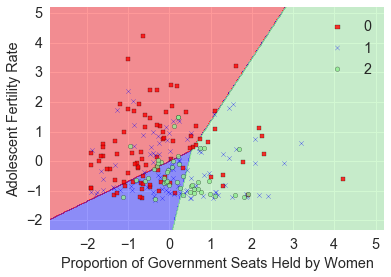

In [20]:
# This code generates a visual plot by calling the plot_decision_regions we defined earlier.

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn)
plt.xlabel('Proportion of Government Seats Held by Women')
plt.ylabel('Adolescent Fertility Rate')
plt.legend(loc='upper right')
plt.show()

In [21]:
# Now that we have looked at one plot we will plot the remaining two combinations of columns, starting with
# the Percentage of Government Seats Held by Women and the Labor Force Participation Rate
# selectedCols = ['SG.GEN.PARL.ZS','SL.TLF.CACT.MA.ZS','SP.ADO.TFRT']
selectedCols = ['SG.GEN.PARL.ZS','SL.TLF.CACT.MA.ZS']
X = df_all_2014[selectedCols]
y = target

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [22]:
# This code standardizes our data values, a necessary step to take since some values are represented in percentages and other
# values are represented as very large integers.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [23]:
# This code builds a Perceptron and fits the training data to it.
from sklearn.linear_model import Perceptron
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [24]:
# This reports the number of samples that were misclassified by the model

y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 40


In [25]:
# This reports the accuracy of our predictor as a percentage

from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.44


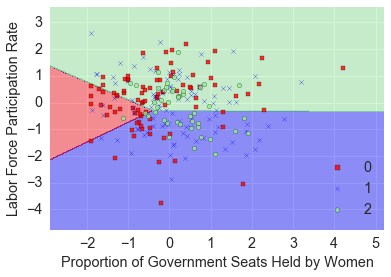

In [26]:
# This code generates a visual plot by calling the plot_decision_regions we defined earlier.

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn)
plt.xlabel('Proportion of Government Seats Held by Women')
plt.ylabel('Labor Force Participation Rate')
plt.legend(loc='lower right')
plt.show()

In [27]:
# Finally we will plot the Adolescent Birth Rate together with the Labor Force Participation Rate.
# selectedCols = ['SG.GEN.PARL.ZS','SL.TLF.CACT.MA.ZS','SP.ADO.TFRT']
selectedCols = ['SP.ADO.TFRT','SL.TLF.CACT.MA.ZS']
X = df_all_2014[selectedCols]
y = target

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [28]:
# This code standardizes our data values, a necessary step to take since some values are represented in percentages and other
# values are represented as very large integers.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [29]:
# This code builds a Perceptron and fits the training data to it.
from sklearn.linear_model import Perceptron
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [30]:
# This reports the number of samples that were misclassified by the model

y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 58


In [31]:
# This reports the accuracy of our predictor as a percentage

from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.18


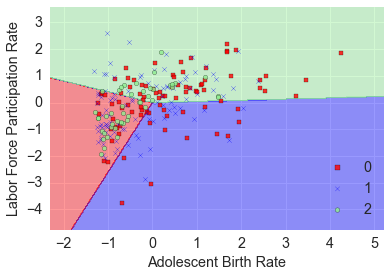

In [32]:
# This code generates a visual plot by calling the plot_decision_regions we defined earlier.

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn)
plt.xlabel('Adolescent Birth Rate')
plt.ylabel('Labor Force Participation Rate')
plt.legend(loc='lower right')
plt.show()

Based upon what we have seen in the visualizations above, the most predictive combination of columns is found by combining the Percentage of Government Seats Held by Women with the Adolescent Birth Rate which had a predictive accuracy of 55%, compared with 44% and 18% for the other models.  This can be seen in the visualizations as well, where we see that the more accurate models show the red "very poor" countries in the predicted red area more often, while the less predictive visualizations have less correlation between the classification of a given object and the predictive area.  
  
In the following section we will now run a similar SVM but with many more indicators used as predictive variables than what we have used thus far.  The expectation is that by using additional predictive variables we will be able to achieve predictive accuracy much higher than 55%, even if the predictions will not be as easily visualized in graph form.

In [33]:
# Here we are once recreating the pivot table and other data, only this time we are not filtering down to just 5 indicator variables.
df_s = df_indicators[['Year','CountryCode','IndicatorCode','Value']]
df_s =df_s.pivot_table(index=['CountryCode','Year'], columns=['IndicatorCode'], values=['Value'])
df_all = df_s['Value']
df_all.reset_index(inplace=True)
df_all.columns.name=None

In [34]:
# Once more we will only be interested in values for these countries from the year 2014.  
# We will also grab just the first 1200 columns so that my Python kernel doesn't crash.
df_all_2014 = df_all[df_all['Year']==2014] 
df_500c_2014 = df_all_2014.ix[:,0:1200]

In [35]:
# This code Imputes missing values in the data based upon a spline method.
df_500c_2014 =df_500c_2014.reindex(index=df_all_2014.index[::-1])
df_500c_2014.interpolate(method='barycentric',order=1, limit_direction='both', inplace=True)
df_500c_2014 =df_500c_2014.reindex(index=df_all_2014.index[::-1])
df_500c_2014.interpolate(method='spline',order=1, limit_direction='both', inplace=True)
df_500c_2014.tail()

,CountryCode,Year,AG.AGR.TRAC.NO,AG.CON.FERT.PT.ZS,AG.CON.FERT.ZS,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,...,SM.POP.REFG.OR,SM.POP.TOTL,SM.POP.TOTL.ZS,SN.ITK.DEFC.ZS,SN.ITK.DFCT,SN.ITK.SALT.ZS,SN.ITK.VITA.ZS,SP.ADO.TFRT,SP.DTH.INFR.ZS,SP.DTH.REPT.ZS
278,ALB,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10140.0,NaN,NaN,NaN,NaN,NaN,NaN,21.4896,NaN,NaN
222,AGO,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9507.0,NaN,NaN,NaN,114.0,NaN,NaN,166.6028,NaN,NaN
166,AFG,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2593368.0,NaN,NaN,NaN,155.0,NaN,NaN,76.7336,NaN,NaN
110,ADO,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,ABW,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.1220,NaN,NaN


In [36]:
# There are many columns that have significant NaNs even after imputation, and we are going to drop any column that has more than 2.
#df_500c_2014.info()
#df_500c_2014.isnull().sum()
i = 2
print(df_500c_2014.ix[:,i].isnull().sum())
array = []
for i in range(2, 1200):
    if df_500c_2014.ix[:,i].isnull().sum() > 2:
        array.append(i)
    i += 1
print(array)

247
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 224, 225, 226, 227, 228, 22

In [37]:
# Here we drop almost all of our columns/indicators, but we still have five countries that have a few NaNs here and there.
df_red_2014 = df_500c_2014.drop(df_500c_2014.columns[[array]], axis=1)
df_red_2014.head()

,CountryCode,Year,AG.LND.TOTL.K2,AG.SRF.TOTL.K2,BM.TRF.PWKR.CD.DT,BX.TRF.PWKR.CD.DT,DT.CUR.UKPS.ZS,DT.DOD.MDRI.CD,DT.INR.OFFT,DT.INT.DECT.GN.ZS,...,SH.STA.BRTC.ZS,SH.STA.MALN.FE.ZS,SH.STA.MALN.MA.ZS,SH.STA.MMRT.NE,SH.STA.ORCF.ZS,SH.STA.ORTH,SH.STA.STNT.FE.ZS,SH.STA.STNT.MA.ZS,SH.STA.WAST.FE.ZS,SH.STA.WAST.MA.ZS
13829,ZWE,2014,386850.0,390760.0,NaN,NaN,4.6765,0.0,0.0000,1.130828,...,NaN,9.800000,12.500000,NaN,NaN,NaN,24.100000,31.100000,2.900000,3.700000
13773,ZMB,2014,743390.0,752610.0,8.119988e+07,5.830030e+07,0.0912,0.0,6.4421,0.591757,...,NaN,1.178157,0.595070,398.0,NaN,NaN,3.376806,2.085196,0.425688,0.293806
13717,ZAR,2014,2267050.0,2344860.0,1.562978e+07,2.237836e+07,0.0000,0.0,0.7500,0.512865,...,80.1,0.896646,0.595102,846.0,39.9,39.1,2.697047,2.085273,0.345186,0.293812
13661,ZAF,2014,1213090.0,1219090.0,1.093586e+09,9.134031e+08,0.0000,0.0,0.4370,1.375103,...,80.1,0.802682,0.595110,1294.0,39.9,39.1,2.467706,2.085291,0.318544,0.293811
13605,YEM,2014,527970.0,527970.0,3.353955e+08,3.350500e+09,0.0000,0.0,0.0000,0.971603,...,80.1,0.758385,0.595111,1742.0,39.9,39.1,2.357392,2.085294,0.306194,0.293808


In [38]:
# dropping the five countries that still had NaNs
df_red_2014 = df_red_2014[df_red_2014['CountryCode'] != 'ZWE']
df_red_2014 = df_red_2014[df_red_2014['CountryCode'] != 'ADO']
df_red_2014 = df_red_2014[df_red_2014['CountryCode'] != 'ABW']
df_red_2014 = df_red_2014[df_red_2014['CountryCode'] != 'SSD']
df_red_2014 = df_red_2014[df_red_2014['CountryCode'] != 'ZMB']

In [39]:
# Now we are left with 78 columns, or indicators, none of which have any missing values.  This seems sufficient for our SVM needs.
df_red_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 13717 to 166
Data columns (total 78 columns):
CountryCode          242 non-null object
Year                 242 non-null int64
AG.LND.TOTL.K2       242 non-null float64
AG.SRF.TOTL.K2       242 non-null float64
BM.TRF.PWKR.CD.DT    242 non-null float64
BX.TRF.PWKR.CD.DT    242 non-null float64
DT.CUR.UKPS.ZS       242 non-null float64
DT.DOD.MDRI.CD       242 non-null float64
DT.INR.OFFT          242 non-null float64
DT.INT.DECT.GN.ZS    242 non-null float64
DT.NFL.NEBR.CD       242 non-null float64
EN.POP.DNST          242 non-null float64
EP.PMP.DESL.CD       242 non-null float64
EP.PMP.SGAS.CD       242 non-null float64
FB.ATM.TOTL.P5       242 non-null float64
FB.CBK.DPTR.P3       242 non-null float64
FP.CPI.TOTL          242 non-null float64
FP.CPI.TOTL.ZG       242 non-null float64
FR.INR.LEND          242 non-null float64
IQ.CPA.BREG.XQ       242 non-null float64
IQ.CPA.DEBT.XQ       242 non-null float64
IQ.CPA.ECON.

In [40]:
# Our response variable had been filtered out during the previous steps so we will add it back in really quick
df_red_2014['NY.GDP.MKTP.CD'] = df_500c_2014['NY.GDP.MKTP.CD']

In [41]:
# This code generates a target array of values, with 0 being very poor, 1 being poor, and 2 being rich

i = 0
rangeLength = len(df_red_2014['NY.GDP.MKTP.CD'])
target = []
for i in range(0,rangeLength):
    if df_red_2014['NY.GDP.MKTP.CD'].iloc[i] > 754000000000:
        target.append(2)
    elif df_red_2014['NY.GDP.MKTP.CD'].iloc[i] > 25000000000:
        target.append(1)
    else:
        target.append(0)
print(target)

[1, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 2, 1, 2, 1, 1, 1, 0, 2, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 2, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 2, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 2, 2, 0, 1, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 2, 1, 0, 2, 1, 0, 1, 1, 1, 2, 0, 2, 1, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1, 1, 2, 1, 1, 2, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0, 1, 1, 2, 0, 0, 0]


In [42]:
# Now that we have our target array created, we will make a new dataframe with the country code, year, and response variable removed
# Referenced code for this section can be found at http://stackoverflow.com/questions/14940743/selecting-excluding-sets-of-columns-in-pandas

df_fin_2014 = df_red_2014.drop(['CountryCode', 'Year', 'NY.GDP.MKTP.CD'], axis=1)
df_fin_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 13717 to 166
Data columns (total 76 columns):
AG.LND.TOTL.K2       242 non-null float64
AG.SRF.TOTL.K2       242 non-null float64
BM.TRF.PWKR.CD.DT    242 non-null float64
BX.TRF.PWKR.CD.DT    242 non-null float64
DT.CUR.UKPS.ZS       242 non-null float64
DT.DOD.MDRI.CD       242 non-null float64
DT.INR.OFFT          242 non-null float64
DT.INT.DECT.GN.ZS    242 non-null float64
DT.NFL.NEBR.CD       242 non-null float64
EN.POP.DNST          242 non-null float64
EP.PMP.DESL.CD       242 non-null float64
EP.PMP.SGAS.CD       242 non-null float64
FB.ATM.TOTL.P5       242 non-null float64
FB.CBK.DPTR.P3       242 non-null float64
FP.CPI.TOTL          242 non-null float64
FP.CPI.TOTL.ZG       242 non-null float64
FR.INR.LEND          242 non-null float64
IQ.CPA.BREG.XQ       242 non-null float64
IQ.CPA.DEBT.XQ       242 non-null float64
IQ.CPA.ECON.XQ       242 non-null float64
IQ.CPA.ENVR.XQ       242 non-null float64
IQ.CPA.FI

In [43]:
X = df_fin_2014
y = target

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [44]:
# This code standardizes our data values, a necessary step to take since some values are represented in percentages and other
# values are represented as very large integers.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [45]:
# This code builds a Perceptron and fits the training data to it.
from sklearn.linear_model import Perceptron
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [46]:
# This reports the number of samples that were misclassified by the model

y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 16


In [47]:
# This reports the accuracy of our predictor as a percentage

from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.67


As expected, by feeding a large number of indicator variables into our SVM we were able to achieve a higher accuracy than we previously were seeing with just two indicator variables.  The accuracy we see with 76 indicators is 67%, a number that is a full twelve points higher than the best prediction we had from 2 indicators, and is the first accuracy score we have seen that is considerably better than a coin flip.  
  
  

## Logistic Regression Model

Please carefully describe every assumption and every step in your report.  
  
  [50 points] Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use
80/20 training/testing split for your data). Adjust parameters of the models to make them more
accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.  


Here, we used the in class **"04. Logits and SVM IPython Notebook**  as a guide.


# Case 1: Logistic Regression¶
Logistic Regression Analysis - Multinomial Classification

* **Python 2.7 skLearn Libraries**
* **Similar to the analysis done with Logistic Regression Model Dr. Eric Larson**

In [53]:
'''
The following code follows to the Google Python Coding Style.
https://google.github.io/styleguide/pyguide.html
'''

# Define a new categorical variable named "Financial-Status" which indicates the financial status of each unique 
# country
# initialize all values to VERY POOR
VERY_POOR = 0
POOR      = 1
RICH      = 2

## Treated pandas DataFrame  df_fin_2014  as the final Data Frame

- What is the response variable and what are the input variables


Created **Financial_Status"** as a response or output variable

Need to know what are the input variables.

In [54]:
# This code generates a new input categorical feature variable name with three distinct values
# with 0 being very poor, 
#      1 being poor, and 
#      2 being rich
#
# This function will work on any generic WDI indicator code.

RICH_MILESTONE_VALUE = 754000000000
POOR_MILESTONE_VALUE = 25000000000

## TO DO
#  THIS CODE CAN BE CHANGED TO 3 (THREE) LINES OF CODE.  I AM TIRED AND I CAN'T THINK OF IT NOW.
#  POSSIBLE BUG WITH THE RANGE CHECKING.  
#    - I WILL INVESTIGATE LATER
def create_categorical_feature_variable(indicator_code, categorical_feature_name):
    i = 0
    range_length = len(df_fin_2014[indicator_code])
    df_fin_2014[categorical_feature_name] = VERY_POOR
    
    for i in range(0,range_length):
        
        if df_fin_2014[indicator_code].iloc[i] > RICH_MILESTONE_VALUE:
            
            df_fin_2014[categorical_feature_name].iloc[i] = RICH
            
        elif df_fin_2014[indicator_code].iloc[i] > POOR_MILESTONE_VALUE: #and df_all_2014['NY.GDP.MKTP.CD'].iloc[i] < 754000000000:
            
            df_fin_2014[categorical_feature_name].iloc[i] = POOR
            
        else:
            df_fin_2014[categorical_feature_name].iloc[i] = VERY_POOR
        
    return 0

In [55]:
# Our response variable had been filtered out during the previous steps so we will add it back in really quick
df_fin_2014['NY.GDP.MKTP.CD'] = df_500c_2014['NY.GDP.MKTP.CD']

In [56]:
# # now use this grouping to fill the data set in each group, then transform back
# fill in the numeric values
df_fin_2014 = df_fin_2014.apply(lambda grp: grp.fillna(grp.median()))

In [57]:
# Create the categorical variable named "Financial-Status" based on the 'NY.GDP.MKTP.CD' indicator code
#
##
##  TO DO:
######    I think the newly created feature "Financial-Status" is equivalent to "target"
#
create_categorical_feature_variable('NY.GDP.MKTP.CD', 'Financial_Status')
df_fin_2014['Financial_Status']    # print the values for a sanity check

C:\Users\Ben\Anaconda6\envs\gl-env\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


13717    1
13661    1
13605    1
13549    0
13493    2
13437    0
13381    0
13325    1
13269    1
13213    1
13157    0
13101    1
13045    2
12989    1
12933    2
12877    1
12821    1
12765    1
12709    0
12653    2
12597    1
12541    1
12485    0
12429    0
12373    1
12317    0
12261    1
12205    0
12149    0
12093    1
        ..
1790     0
1734     0
1678     0
1622     0
1566     2
1510     1
1454     1
1398     0
1342     1
1286     0
1230     0
1174     1
1118     1
1062     1
1006     0
950      0
894      1
838      0
782      1
726      1
670      2
614      0
558      1
502      0
446      1
390      1
334      2
278      0
222      1
166      0
Name: Financial_Status, dtype: int64

In [58]:
print "Number of items in the array: {}".format(len(df_fin_2014['Financial_Status']))

Number of items in the array: 242


In [59]:
# Now we have 235 countries with no missing values.
# Also, verify the new "Financial-Status" feature
df_fin_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 13717 to 166
Data columns (total 78 columns):
AG.LND.TOTL.K2       242 non-null float64
AG.SRF.TOTL.K2       242 non-null float64
BM.TRF.PWKR.CD.DT    242 non-null float64
BX.TRF.PWKR.CD.DT    242 non-null float64
DT.CUR.UKPS.ZS       242 non-null float64
DT.DOD.MDRI.CD       242 non-null float64
DT.INR.OFFT          242 non-null float64
DT.INT.DECT.GN.ZS    242 non-null float64
DT.NFL.NEBR.CD       242 non-null float64
EN.POP.DNST          242 non-null float64
EP.PMP.DESL.CD       242 non-null float64
EP.PMP.SGAS.CD       242 non-null float64
FB.ATM.TOTL.P5       242 non-null float64
FB.CBK.DPTR.P3       242 non-null float64
FP.CPI.TOTL          242 non-null float64
FP.CPI.TOTL.ZG       242 non-null float64
FR.INR.LEND          242 non-null float64
IQ.CPA.BREG.XQ       242 non-null float64
IQ.CPA.DEBT.XQ       242 non-null float64
IQ.CPA.ECON.XQ       242 non-null float64
IQ.CPA.ENVR.XQ       242 non-null float64
IQ.CPA.FI

In [60]:
df_fin_2014.head()

,AG.LND.TOTL.K2,AG.SRF.TOTL.K2,BM.TRF.PWKR.CD.DT,BX.TRF.PWKR.CD.DT,DT.CUR.UKPS.ZS,DT.DOD.MDRI.CD,DT.INR.OFFT,DT.INT.DECT.GN.ZS,DT.NFL.NEBR.CD,EN.POP.DNST,...,SH.STA.MALN.MA.ZS,SH.STA.MMRT.NE,SH.STA.ORCF.ZS,SH.STA.ORTH,SH.STA.STNT.FE.ZS,SH.STA.STNT.MA.ZS,SH.STA.WAST.FE.ZS,SH.STA.WAST.MA.ZS,NY.GDP.MKTP.CD,Financial_Status
13717,2267050.0,2344860.0,1.562978e+07,2.237836e+07,0.000000,0.0,0.750000,0.512865,0.0,33.028398,...,0.595102,846.0,39.9,39.1,2.697047,2.085273,0.345186,0.293812,3.312107e+10,1
13661,1213090.0,1219090.0,1.093586e+09,9.134031e+08,0.000000,0.0,0.437000,1.375103,0.0,44.516032,...,0.595110,1294.0,39.9,39.1,2.467706,2.085291,0.318544,0.293811,3.500850e+11,1
13605,527970.0,527970.0,3.353955e+08,3.350500e+09,0.000000,0.0,0.000000,0.971603,0.0,49.593113,...,0.595111,1742.0,39.9,39.1,2.357392,2.085294,0.306194,0.293808,5.616464e+10,1
13549,2830.0,2840.0,1.246791e+07,1.405020e+08,0.000000,0.0,2.000000,0.734422,0.0,67.789753,...,0.595111,2190.0,39.9,39.1,2.296325,2.085291,0.299815,0.293804,8.004190e+08,0
13493,129736256.7,134325255.2,3.912467e+11,5.108721e+11,0.261596,0.0,1.093467,0.970419,0.0,55.964712,...,0.595109,2638.0,39.9,39.1,2.260817,2.085285,0.296589,0.293800,7.784511e+13,2


In [61]:
df_fin_2014.tail()

,AG.LND.TOTL.K2,AG.SRF.TOTL.K2,BM.TRF.PWKR.CD.DT,BX.TRF.PWKR.CD.DT,DT.CUR.UKPS.ZS,DT.DOD.MDRI.CD,DT.INR.OFFT,DT.INT.DECT.GN.ZS,DT.NFL.NEBR.CD,EN.POP.DNST,...,SH.STA.MALN.MA.ZS,SH.STA.MMRT.NE,SH.STA.ORCF.ZS,SH.STA.ORTH,SH.STA.STNT.FE.ZS,SH.STA.STNT.MA.ZS,SH.STA.WAST.FE.ZS,SH.STA.WAST.MA.ZS,NY.GDP.MKTP.CD,Financial_Status
390,83600.0,83600.0,9.993789e+09,1.460079e+10,0.039720,0.0,1.241591,0.831858,0.0,108.685873,...,0.597701,107462.0,39.9,39.1,1.619226,2.093063,0.203055,0.297069,3.994513e+11,1
334,13621411.0,13152838.5,8.608096e+10,4.021277e+10,0.038772,0.0,1.242224,0.831266,0.0,28.284334,...,0.597668,107910.0,39.9,39.1,1.619647,2.092963,0.203119,0.297026,2.845788e+12,2
278,27400.0,28750.0,1.786777e+08,1.141665e+09,0.000000,0.0,0.826300,0.722078,0.0,105.637774,...,0.597636,108358.0,39.9,39.1,1.620059,2.092866,0.203183,0.296985,1.321151e+10,0
222,1246700.0,1246700.0,1.298816e+09,1.443187e+10,0.034900,0.0,2.893100,0.867291,0.0,19.433323,...,0.597605,108806.0,39.9,39.1,1.620465,2.092772,0.203245,0.296946,5.616464e+10,1
166,652860.0,652860.0,2.435160e+08,2.680607e+08,0.000000,0.0,0.000000,0.048538,0.0,48.444546,...,0.597575,109254.0,39.9,39.1,1.620864,2.092681,0.203307,0.296907,2.003822e+10,0


In [368]:
# NOTE: calling describe when not all the data is categorical will cause the 
# categorical variables to be removed
'''
df_all_2014[['Financial_Status']].describe().transpose()
'''

"\ndf_all_2014[['Financial_Status']].describe().transpose()\n"

In [369]:
# perform one-hot encoding of the categorical data "Financial-Status"
'''
tmp_df = pd.get_dummies(df_all_2014['Financial_Status'],prefix='Financial_Status')
df_all_2014 = pd.concat((df_all_2014,tmp_df),axis=1) # add back into the dataframe


df_all_2014.info()
'''

"\ntmp_df = pd.get_dummies(df_all_2014['Financial_Status'],prefix='Financial_Status')\ndf_all_2014 = pd.concat((df_all_2014,tmp_df),axis=1) # add back into the dataframe\n\n\ndf_all_2014.info()\n"

In [370]:
# Now let's clean up the dataset
'''
if 'Financial_Status' in df_all_2014:    
    del df_all_2014['Financial_Status'] # get rid of the original category as it is now one-hot encoded
    
df_all_2014.info()
'''

"\nif 'Financial_Status' in df_all_2014:    \n    del df_all_2014['Financial_Status'] # get rid of the original category as it is now one-hot encoded\n    \ndf_all_2014.info()\n"

In [62]:
df_all_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 54 to 13829
Columns: 1346 entries, CountryCode to per_si_allsi.cov_pop_tot
dtypes: float64(1344), int64(1), object(1)
memory usage: 2.5+ MB


In [63]:
df_fin_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 13717 to 166
Data columns (total 78 columns):
AG.LND.TOTL.K2       242 non-null float64
AG.SRF.TOTL.K2       242 non-null float64
BM.TRF.PWKR.CD.DT    242 non-null float64
BX.TRF.PWKR.CD.DT    242 non-null float64
DT.CUR.UKPS.ZS       242 non-null float64
DT.DOD.MDRI.CD       242 non-null float64
DT.INR.OFFT          242 non-null float64
DT.INT.DECT.GN.ZS    242 non-null float64
DT.NFL.NEBR.CD       242 non-null float64
EN.POP.DNST          242 non-null float64
EP.PMP.DESL.CD       242 non-null float64
EP.PMP.SGAS.CD       242 non-null float64
FB.ATM.TOTL.P5       242 non-null float64
FB.CBK.DPTR.P3       242 non-null float64
FP.CPI.TOTL          242 non-null float64
FP.CPI.TOTL.ZG       242 non-null float64
FR.INR.LEND          242 non-null float64
IQ.CPA.BREG.XQ       242 non-null float64
IQ.CPA.DEBT.XQ       242 non-null float64
IQ.CPA.ECON.XQ       242 non-null float64
IQ.CPA.ENVR.XQ       242 non-null float64
IQ.CPA.FI

# Training and Testing Split

For training and testing purposes, let's gather the data we have and grab 80% of the instances for training and the remaining 20% for testing. Moreover, let's repeat this process of separating the testing and training data three times. We will use the hold out cross validation method built into scikit-learn.

In [64]:
from sklearn.cross_validation import ShuffleSplit

# we want to predict the X and y data as follows:
if 'Financial_Status' in df_fin_2014:
    y = df_fin_2014['Financial_Status'].values # get the labels we want
    del df_fin_2014['Financial_Status'] # get rid of the class label
    X = df_fin_2014.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(242, n_iter=3, test_size=0.2, random_state=None)


# Logistic Regression

Now let's use Logistic Regression from `scikit-learn`. The documentation can be found here:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [65]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set predictions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

('====Iteration', 0, ' ====')
('accuracy', 0.53061224489795922)
('confusion matrix\n', array([[ 4,  9,  2],
       [ 1, 12, 11],
       [ 0,  0, 10]]))
('====Iteration', 1, ' ====')
('accuracy', 0.69387755102040816)
('confusion matrix\n', array([[12,  5,  3],
       [ 0, 15,  7],
       [ 0,  0,  7]]))
('====Iteration', 2, ' ====')
('accuracy', 0.48979591836734693)
('confusion matrix\n', array([[ 5,  7,  3],
       [ 0, 15, 14],
       [ 0,  1,  4]]))


In [66]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.cross_validation import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[ 0.57142857  0.59183673  0.55102041]


In [67]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05))

[ 0.65306122  0.55102041  0.46938776]


<function __main__.lr_explor>

# Interpretting weights

Okay, so now lets take the last trained model for logistic regression and try to interpret the weights for the model. Is there something about the weights that makes this model more interpretable?

In [68]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_fin_2014.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 

('AG.LND.TOTL.K2', 'has weight of', 2.0945129524707645e-14)
('AG.SRF.TOTL.K2', 'has weight of', 2.1357229061913777e-14)
('BM.TRF.PWKR.CD.DT', 'has weight of', 2.1586300054572139e-12)
('BX.TRF.PWKR.CD.DT', 'has weight of', 1.0832750645700172e-10)
('DT.CUR.UKPS.ZS', 'has weight of', 1.2857743677149542e-20)
('DT.DOD.MDRI.CD', 'has weight of', 0.0)
('DT.INR.OFFT', 'has weight of', 1.3957301063136595e-19)
('DT.INT.DECT.GN.ZS', 'has weight of', 1.329982521296766e-19)
('DT.NFL.NEBR.CD', 'has weight of', 0.0)
('EN.POP.DNST', 'has weight of', -5.3353854025780666e-18)
('EP.PMP.DESL.CD', 'has weight of', 1.6830346423420626e-19)
('EP.PMP.SGAS.CD', 'has weight of', 1.7955694578969816e-19)
('FB.ATM.TOTL.P5', 'has weight of', 4.2790239274259992e-18)
('FB.CBK.DPTR.P3', 'has weight of', 9.3273404977557068e-17)
('FP.CPI.TOTL', 'has weight of', 1.620795443337172e-17)
('FP.CPI.TOTL.ZG', 'has weight of', 4.8002724817096122e-19)
('FR.INR.LEND', 'has weight of', 1.7366157660042734e-18)
('IQ.CPA.BREG.XQ', 'ha

In [69]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_fin_2014.columns) # combine attributes
#zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

('accuracy:', 0.75510204081632648)
[[19  2  0]
 [ 7 12  0]
 [ 1  2  6]]
('AG.LND.TOTL.K2', 'has weight of', -0.34315103882358999)
('AG.SRF.TOTL.K2', 'has weight of', -0.34043188852557216)
('BM.TRF.PWKR.CD.DT', 'has weight of', -0.0118250559635529)
('BX.TRF.PWKR.CD.DT', 'has weight of', -0.12241281944069712)
('DT.CUR.UKPS.ZS', 'has weight of', -0.25788561283610067)
('DT.DOD.MDRI.CD', 'has weight of', 0.0)
('DT.INR.OFFT', 'has weight of', -0.18913132487893861)
('DT.INT.DECT.GN.ZS', 'has weight of', 0.092219530999713153)
('DT.NFL.NEBR.CD', 'has weight of', 0.0)
('EN.POP.DNST', 'has weight of', 0.012894579073460281)
('EP.PMP.DESL.CD', 'has weight of', 0.25178704713138955)
('EP.PMP.SGAS.CD', 'has weight of', 0.10989536770752856)
('FB.ATM.TOTL.P5', 'has weight of', -0.13162229158854805)
('FB.CBK.DPTR.P3', 'has weight of', 0.12234236811586123)
('FP.CPI.TOTL', 'has weight of', 0.065864676368858011)
('FP.CPI.TOTL.ZG', 'has weight of', 0.044769674065237304)
('FR.INR.LEND', 'has weight of', 0.071

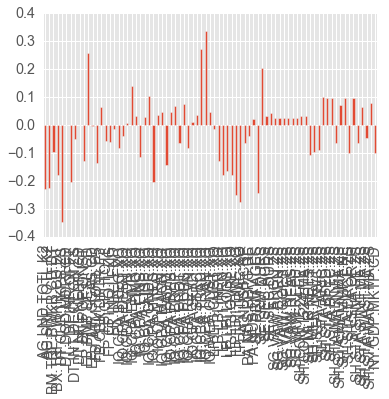

In [72]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df_fin_2014.columns)
weights.plot(kind='bar')
plt.show()

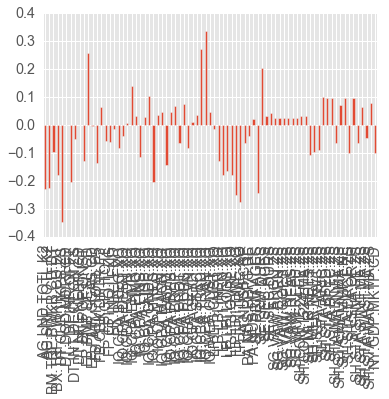

In [71]:
# you can also apply the StandardScaler function insied of the validation loop 
#  but this requires the use of PipeLines in scikit. Here is an example, 
# but we will go over more 
#  thorough examples later in class

from sklearn.pipeline import Pipeline

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl), ('logit_model', lr_clf)])

# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    
# it is a little odd getting trained objects from a  pipeline:
trained_model_from_pipeline = piped_object.named_steps['logit_model']

# now look at the weights
weights = pd.Series(trained_model_from_pipeline.coef_[0],index=df_fin_2014.columns)
weights.plot(kind='bar')
plt.show()

# Case 2: Logistic Regression - Graphlab Create Turi

# Another Style of Solving This Problem



# Important Modules


#  Graphlab Create Turi

In [73]:
'''
To run this code, YOU MUST MAKE SURE YOU ARE IN THE CORRECT Anaconda Environment!!
RUN THIS COMMAND IN AN ANACONDA COMMAND WINDOW BEFORE EXECUTING THE CODE:
==> activate gl-env
'''

import graphlab as gl
import graphlab

# keep data visualizations within notebook
graphlab.canvas.set_target('ipynb')

# Re-do

Must add back in Financial_Status column

In [74]:
# Create the categorical variable named "Financial-Status" based on the 'NY.GDP.MKTP.CD' indicator code
#
##
##  TO DO:
######    I think the newly created feature "Financial-Status" is equivalent to "target"
#
create_categorical_feature_variable('NY.GDP.MKTP.CD', 'Financial_Status')
df_fin_2014['Financial_Status']    # print the values for a sanity check

13717    1
13661    1
13605    1
13549    0
13493    2
13437    0
13381    0
13325    1
13269    1
13213    1
13157    0
13101    1
13045    2
12989    1
12933    2
12877    1
12821    1
12765    1
12709    0
12653    2
12597    1
12541    1
12485    0
12429    0
12373    1
12317    0
12261    1
12205    0
12149    0
12093    1
        ..
1790     0
1734     0
1678     0
1622     0
1566     2
1510     1
1454     1
1398     0
1342     1
1286     0
1230     0
1174     1
1118     1
1062     1
1006     0
950      0
894      1
838      0
782      1
726      1
670      2
614      0
558      1
502      0
446      1
390      1
334      2
278      0
222      1
166      0
Name: Financial_Status, dtype: int64

In [78]:
# Here we will use the Graph Lab Create API to create a SFRAME based on the pandas DataFrame created earlier.
# instantiate a SFRAME based on the input DataFrame named "df_all_2014"

'''
To run this code, you MUST MAKE SURE YOU ARE IN THE CORRECT Anaconda Environment!!
RUN THIS COMMAND IN AN ANACONDA COMMAND WINDOW:
==> activate gl-env
'''
sf_final_2014 = gl.SFrame(df_fin_2014)

This non-commercial license of GraphLab Create for academic use is assigned to bbrock@smu.edu and will expire on August 17, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\Ben\AppData\Local\Temp\graphlab_server_1476053699.log.0


In [79]:
sf_final_2014.show()

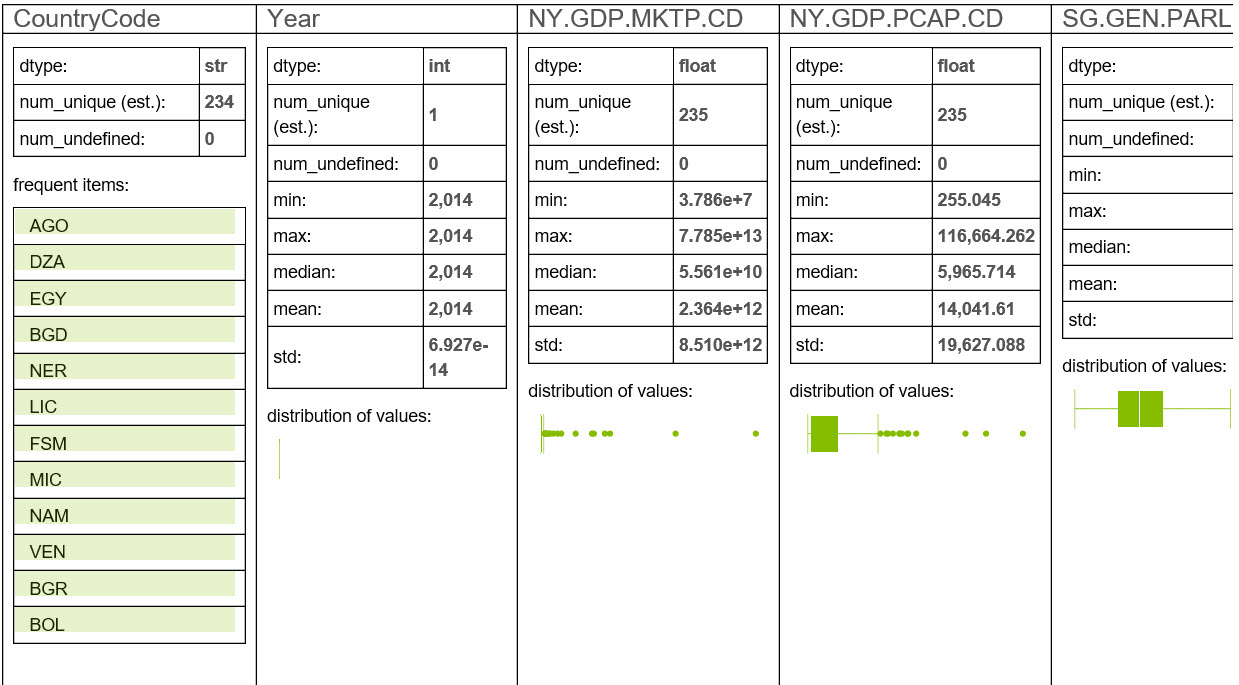

In [90]:
from IPython.display import Image 
Image(filename="images/sf_all_2014_show_method.jpg")

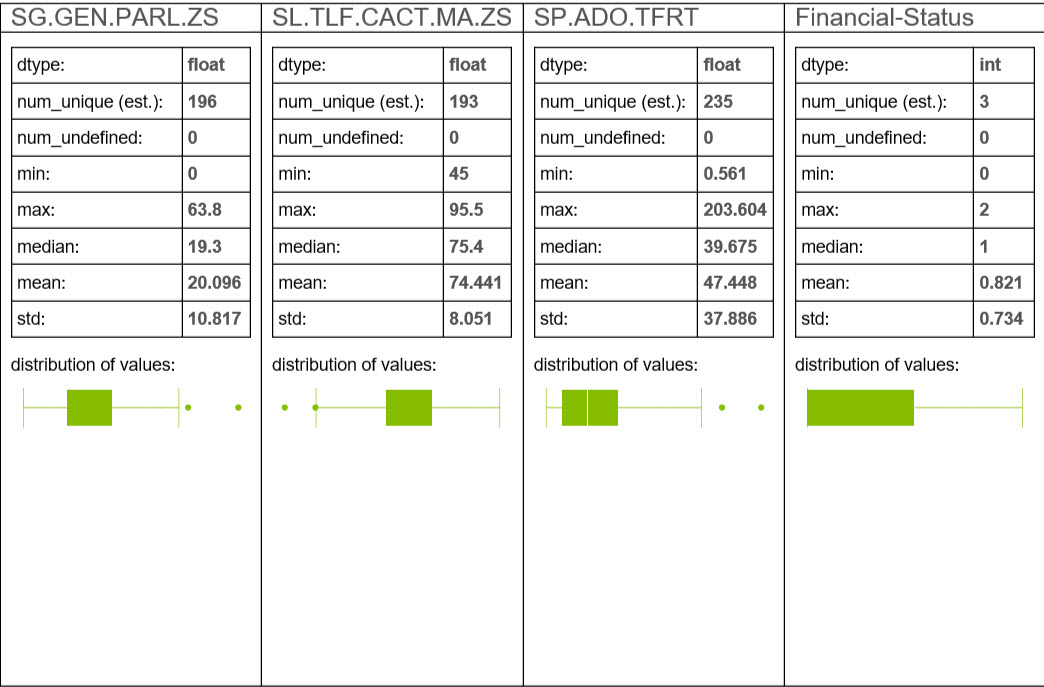

In [91]:
from IPython.display import Image 
Image(filename="images/sf_all_2014_show_method-next.jpg")

In [80]:
sf_final_2014['Financial_Status'].show(view='Categorical')

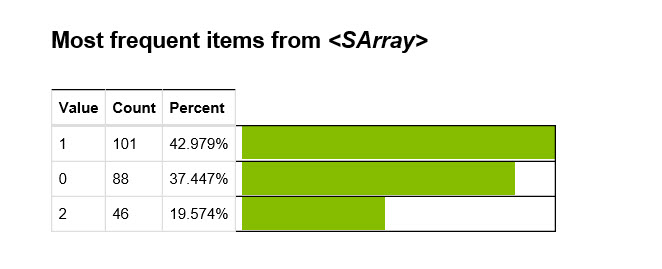

In [93]:
from IPython.display import Image 
Image(filename="images/sf_all_2014-financial-status-show-categorical.jpg")

In [94]:
# Another way of showing the distribution of the categorical variable breakdown usage.
sf_final_2014['Financial_Status'].show()

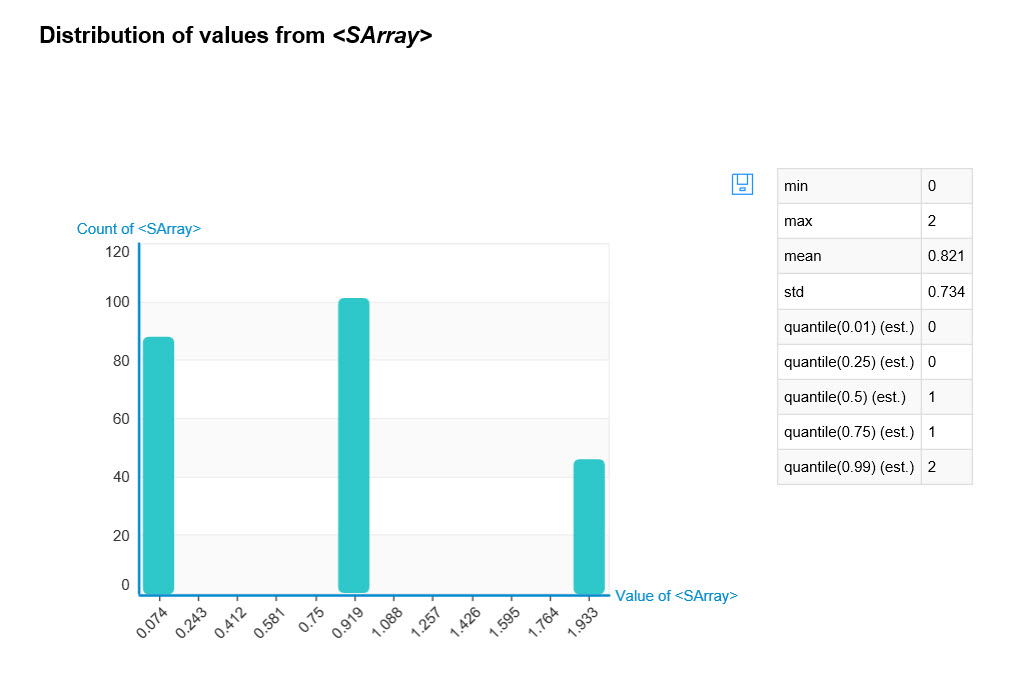

In [95]:
from IPython.display import Image 
Image(filename="images/sf_all_2014_fs_show_histogram.jpg")

# Data Visualization

In [96]:
# show plots in the notebook
%matplotlib inline

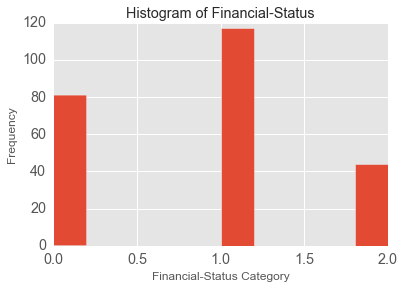

In [81]:
# histogram of Financial Status
df_fin_2014["Financial_Status"].hist()
plt.title('Histogram of Financial-Status')
plt.xlabel('Financial-Status Category')
plt.ylabel('Frequency')

In [82]:
'''
Here, we have created our custom features based on the data set.
'''
my_custom_features = sf_final_2014.column_names()
my_custom_features.remove("Financial_Status")
print my_custom_features

['AG.LND.TOTL.K2', 'AG.SRF.TOTL.K2', 'BM.TRF.PWKR.CD.DT', 'BX.TRF.PWKR.CD.DT', 'DT.CUR.UKPS.ZS', 'DT.DOD.MDRI.CD', 'DT.INR.OFFT', 'DT.INT.DECT.GN.ZS', 'DT.NFL.NEBR.CD', 'EN.POP.DNST', 'EP.PMP.DESL.CD', 'EP.PMP.SGAS.CD', 'FB.ATM.TOTL.P5', 'FB.CBK.DPTR.P3', 'FP.CPI.TOTL', 'FP.CPI.TOTL.ZG', 'FR.INR.LEND', 'IQ.CPA.BREG.XQ', 'IQ.CPA.DEBT.XQ', 'IQ.CPA.ECON.XQ', 'IQ.CPA.ENVR.XQ', 'IQ.CPA.FINQ.XQ', 'IQ.CPA.FINS.XQ', 'IQ.CPA.FISP.XQ', 'IQ.CPA.GNDR.XQ', 'IQ.CPA.HRES.XQ', 'IQ.CPA.IRAI.XQ', 'IQ.CPA.MACR.XQ', 'IQ.CPA.PADM.XQ', 'IQ.CPA.PRES.XQ', 'IQ.CPA.PROP.XQ', 'IQ.CPA.PROT.XQ', 'IQ.CPA.PUBS.XQ', 'IQ.CPA.REVN.XQ', 'IQ.CPA.SOCI.XQ', 'IQ.CPA.STRC.XQ', 'IQ.CPA.TRAD.XQ', 'IQ.CPA.TRAN.XQ', 'IQ.WEF.CUST.XQ', 'LP.LPI.CUST.XQ', 'LP.LPI.INFR.XQ', 'LP.LPI.ITRN.XQ', 'LP.LPI.LOGS.XQ', 'LP.LPI.OVRL.XQ', 'LP.LPI.TIME.XQ', 'LP.LPI.TRAC.XQ', 'PA.NUS.FCRF', 'PA.NUS.PPPC.RF', 'PA.NUS.PRVT.PP', 'SE.PRM.AGES', 'SE.PRM.DURS', 'SE.SEC.AGES', 'SE.SEC.DURS', 'SG.VAW.ARGU.ZS', 'SG.VAW.BURN.ZS', 'SG.VAW.GOES.ZS', 'SG.VAW.N

# Logistic Regression


The Logistic Regression solution was based upon using the Turi Machine Learning Platform.  Here our goal was to get experience in using both the scipy/sklearn and the Turi Machine Learning platforms.  


In [83]:
# Make a train-test split
# split data .8 and seed = 0
train_data, test_data = sf_final_2014.random_split(0.8, seed=0) # get training and test data

In [84]:
# Make a logistic regression model
# The model is trained with the training data (train_data)
rich_country_analyzer_model = graphlab.logistic_classifier.create(train_data, 
                                                                  target = 'Financial_Status', 
                                                                  features = my_custom_features)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



WARNING: Detected extremely low variance for feature(s) 'DT.DOD.MDRI.CD', 'DT.NFL.NEBR.CD' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Logistic regression:

--------------------------------------------------------

Number of examples          : 197

Number of classes           : 3

Number of feature columns   : 77

Number of unpacked features : 77

Number of coefficients    : 156

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 1.025771     | 0.822335          | 0.571429            |

| 2         | 3        | 1.036774     | 0.868020          | 0.571429            |

| 3         | 4        | 1.046781     | 0.903553          | 0.571429            |

| 4         | 5        | 1.055786     | 0.893401          | 0.571429            |

| 5         | 6        | 1.064795     | 0.923858          | 0.571429            |

| 6         | 7        | 1.070798     | 0.939086          | 0.571429            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

# Evaluate the simple rich_country_analyzer model


In [85]:
# Evaluate the model and save the results into a dictionary
print rich_country_analyzer_model.evaluate(test_data)

{'f1_score': 0.7332818532818534, 'auc': 0.8589236794044227, 'recall': 0.7360066833751043, 'precision': 0.7315832315832317, 'log_loss': 0.8797545491519893, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int
	class	int

Rows: 300003

Data:
+-----------+----------------+-----+----+----+-------+
| threshold |      fpr       | tpr | p  | n  | class |
+-----------+----------------+-----+----+----+-------+
|    0.0    |      1.0       | 1.0 | 12 | 26 |   0   |
|   1e-05   | 0.653846153846 | 1.0 | 12 | 26 |   0   |
|   2e-05   | 0.653846153846 | 1.0 | 12 | 26 |   0   |
|   3e-05   | 0.653846153846 | 1.0 | 12 | 26 |   0   |
|   4e-05   | 0.653846153846 | 1.0 | 12 | 26 |   0   |
|   5e-05   | 0.653846153846 | 1.0 | 12 | 26 |   0   |
|   6e-05   | 0.653846153846 | 1.0 | 12 | 26 |   0   |
|   7e-05   | 0.653846153846 | 1.0 | 12 | 26 |   0   |
|   8e-05   | 0.653846153846 | 1.0 | 12 | 26 |   0   |
|   9e-05   | 0.653846153846 | 1.0 | 12 | 26 |   0   |
+-----------+----------

In [86]:
rich_country_analyzer_model.get('coefficients')   # get the weights

name,index,class,value,stderr
(intercept),None,1,-9.94645938887,nan
AG.LND.TOTL.K2,None,1,5.18587244072e-07,nan
AG.SRF.TOTL.K2,None,1,4.97722348782e-07,nan
BM.TRF.PWKR.CD.DT,None,1,8.74205252192e-11,nan
BX.TRF.PWKR.CD.DT,None,1,2.8483350194e-14,nan
DT.CUR.UKPS.ZS,None,1,1.19462062024,nan
DT.DOD.MDRI.CD,None,1,0.0,nan
DT.INR.OFFT,None,1,0.644031172507,nan
DT.INT.DECT.GN.ZS,None,1,-0.0162788452128,nan
DT.NFL.NEBR.CD,None,1,0.0,nan


# Logistic Regression Analysis
We will now discuss some advanced features that are specific to logistic regression. Making Predictions
Predictions using a GraphLab Create classifier is easy. The classify() method provides a one-stop shop for all that you need from a classifier. 

**TO DO:**

 **NEED TO FILL THIS OUT LATER.**
 
 **IT MIGHT BE GOOD JUST HAVE A BINARY CATEGORICAL VARIABLE.**

In [87]:
# Save predictions (probability estimates) to an SArray
predictions = rich_country_analyzer_model.classify(test_data)
print predictions

+-------+----------------+
| class |  probability   |
+-------+----------------+
|   2   |      1.0       |
|   1   | 0.966678474335 |
|   1   | 0.898247382922 |
|   1   | 0.645674817376 |
|   0   | 0.866548623067 |
|   0   | 0.626735981417 |
|   2   | 0.974478838928 |
|   1   | 0.986188773882 |
|   1   | 0.969609911643 |
|   2   |      1.0       |
+-------+----------------+
[38 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


# GraphLab Create's logistic regression model can return predictions for any of these types:

In [88]:
class_predictions = rich_country_analyzer_model.predict(test_data, output_type = "class")  # Class

# Evaluating Results

We can also evaluate our predictions by comparing them to known ratings. The results are evaluated using two metrics:

    Classification Accuracy: Fraction of test set examples with correct class label predictions.
    Confusion Matrix: Cross- tabulation of predicted and actual class labels.


In [89]:
result = rich_country_analyzer_model.evaluate(test_data)
print "Accuracy         : %s" % result['accuracy']
print "Confusion Matrix : \n%s" % result['confusion_matrix']

Accuracy         : 0.710526315789
Confusion Matrix : 
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      0       |        1        |   4   |
|      1       |        1        |   13  |
|      2       |        2        |   6   |
|      0       |        0        |   8   |
|      1       |        0        |   5   |
|      1       |        2        |   1   |
|      2       |        1        |   1   |
+--------------+-----------------+-------+
[7 rows x 3 columns]



## Compare the advantages of each model  
  
   Please carefully
describe every assumption and every step in your report.  
  
   [10 points] Discuss the advantages of each model for each classification task. Does one type
of model offer superior performance over another in terms of prediction accuracy? In terms of
training time or efficiency? Explain in detail.

## Use Weights to Interpret the Importance of each Feature  
  
  Please carefully describe every assumption and every step in your report.  
    
    [30 points] Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?

## Interpret the chosen Support Vectors  
  
  Please carefully describe every assumption and every step in your report.  
    
     [10 points] Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain.